In [154]:
import csv                               # csv reader
from sklearn.svm import LinearSVC
from nltk.classify import SklearnClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_recall_fscore_support # to report on precision and recall
import numpy as np
import nltk
import pandas as pd
nltk.download('wordnet')
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
import re

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nikhi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [155]:
def load_data(path):
    """Load data from a tab-separated file and append it to raw_data."""
    with open(path) as f:
        reader = csv.reader(f, delimiter='\t')
        for line in reader:
            if line[0] == "Id":  # skip header
                continue
            (label, text) = parse_data_line(line)
            raw_data.append((text, label))

def split_and_preprocess_data(percentage):
    """Split the data between train_data and test_data according to the percentage
    and performs the preprocessing."""
    num_samples = len(raw_data)
    num_training_samples = int((percentage * num_samples))
    for (text, label) in raw_data[:num_training_samples]:
        train_data.append((to_feature_vector(pre_process(text)),label))
    for (text, label) in raw_data[num_training_samples:]:
        test_data.append((to_feature_vector(pre_process(text)),label))

Input and Basic preprocessing

In [156]:
def parse_data_line(line):
    if len(line) >= 2:
        label= line[1]
        statement =line[2]  
    else:
        
        label, statement = None, None  
    return label, statement




In [157]:
def pre_process(text):
    # Should return a list of tokens
    text = re.sub(r"(\w)([.,;:!?'\"”\)])", r"\1 \2", text)  # separates punctuation at ends of strings
    text = re.sub(r"([.,;:!?'\"“\(\)])(\w)", r"\1 \2", text)  # separates punctuation at the beginning of strings
    # print("tokenizing:", text)  # uncomment for debugging
    tokens = re.split(r"\s+", text)
    # normalization - only by lower casing for now
    tokens = [t.lower() for t in tokens]

    return tokens
print(pre_process("We love you,@HillaryClinton! We are always #StillWithHer! 💙 You deserved to win!#recount #faithlesselectors #AuditTheVote You are a hero! 💙"))
    


['we', 'love', 'you', ',@hillaryclinton', '!', 'we', 'are', 'always', '#stillwithher', '!', '💙', 'you', 'deserved', 'to', 'win', '!#recount', '#faithlesselectors', '#auditthevote', 'you', 'are', 'a', 'hero', '!', '💙']


Basic Feature Extraction

In [158]:
global_feature_dict = {} # A global dictionary of features

def to_feature_vector(tokens):
    feature_vector = {}
    for word in tokens:
        if word not in global_feature_dict:
            global_feature_dict[word] = 1
        if word in feature_vector:
            feature_vector[word] += 1
        else:
            feature_vector[word] = 1
    return feature_vector

In [159]:
# TRAINING AND VALIDATING OUR CLASSIFIER

def train_classifier(data):
    print("Training Classifier...")
    pipeline =  Pipeline([('svc', LinearSVC())])
    return SklearnClassifier(pipeline).train(data)

Cross-validation

In [160]:
def cv_results(results):

    sum_precision = 0
    sum_recall = 0
    sum_f1_score = 0
    n = len(results)

    for result in results:
        
        sum_precision += result['weighted avg']['precision']
        sum_recall += result['weighted avg']['recall']
        sum_f1_score += result['weighted avg']['f1-score']

    
    avg_precision = sum_precision / n
    avg_recall = sum_recall / n
    avg_f1_score = sum_f1_score / n
    print('Average Precision:', avg_precision)
    print('Average Recall:', avg_recall)
    print('Average F1 Score:', avg_f1_score)  
    return avg_precision, avg_recall, avg_f1_score
    

In [161]:

from sklearn.metrics import classification_report

def cross_validate(dataset, folds):
    results = []
    fold_size = int(len(dataset) / folds) + 1

    for i in range(0, len(dataset), fold_size):
        test_data = dataset[i:i + fold_size]
        train_data = dataset[:i] + dataset[i + fold_size:]

        classifier = train_classifier(train_data)
        predicted = predict_labels([sample[0] for sample in test_data], classifier)
        actual = [sample[1] for sample in test_data]

        results.append(classification_report(actual, predicted, output_dict=True))
        print("Fold start on items %d - %d" % (i, i + fold_size))

    return cv_results(results)



In [162]:
# PREDICTING LABELS GIVEN A CLASSIFIER

def predict_labels(samples, classifier):
    """Assuming preprocessed samples, return their predicted labels from the classifier model."""
    return classifier.classify_many(samples)

def predict_label_from_raw(sample, classifier):
    """Assuming raw text, return its predicted label from the classifier model."""
    processed_sample = to_feature_vector(pre_process(sample))
    return classifier.classify(to_feature_vector(pre_process(reviewSample)))

In [163]:

# loading reviews
def load_data(path, raw_data):
    with open(path, 'r', encoding='utf-8') as f:
      reader = csv.reader(f, delimiter='\t')
      next(reader, None)  
      for line in reader:
       label, text = parse_data_line(line)
       raw_data.append((text, label))
# initialize global lists that will be appended to by the methods below
def split_and_preprocess_data(raw_data, percentage):
    num_samples = len(raw_data)
    num_training_samples = int(percentage * num_samples)

   
    train_data = [(to_feature_vector(pre_process(text)), label) for text, label in raw_data[:num_training_samples]]
    test_data = [(to_feature_vector(pre_process(text)), label) for text, label in raw_data[num_training_samples:]]

    return train_data, test_data


raw_data = []          # the filtered data from the dataset file
train_data = []        # the pre-processed training data as a percentage of the total dataset
test_data = []         # the pre-processed test data as a percentage of the total dataset


# references to the data files
data_file_path = 'sentiment-dataset.tsv'

# Do the actual stuff (i.e. call the functions we've made)
# We parse the dataset and put it in a raw data list
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing the dataset...",sep='\n')

load_data(data_file_path,raw_data) 

# We split the raw dataset into a set of training data and a set of test data (80/20)
# You do the cross validation on the 80% (training data)
# We print the number of training samples and the number of features before the split
print("Now %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Preparing training and test data...",sep='\n')

train_data, test_data=split_and_preprocess_data(raw_data,0.8)

# We print the number of training samples and the number of features after the split
print("After split, %d rawData, %d trainData, %d testData" % (len(raw_data), len(train_data), len(test_data)),
      "Training Samples: ", len(train_data), "Features: ", len(global_feature_dict), sep='\n')


Now 0 rawData, 0 trainData, 0 testData
Preparing the dataset...
Now 33539 rawData, 0 trainData, 0 testData
Preparing training and test data...


After split, 33539 rawData, 26831 trainData, 6708 testData
Training Samples: 
26831
Features: 
64640


In [164]:
pred=cross_validate(train_data, 10)  # will work and output overall performance of p, r, f-score when cv implemented

print(pred)
#     # Perform cross-validation
#     scores = cross_val_score(model, features, labels, cv=10)  # 10-fold cross-validation
#     return scores.mean()  # Return the mean accurxx
# print(cross_validation)

Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 0 - 2684
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 2684 - 5368
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 5368 - 8052
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 8052 - 10736
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 10736 - 13420
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 13420 - 16104
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 16104 - 18788
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 18788 - 21472
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 21472 - 24156
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Fold start on items 24156 - 26840
Average Precision: 0.8496857708146048
Average Recall: 0.8506240093597226
Average F1 Score: 0.8498411624920671
(0.8496857708146048, 0.8506240093597226, 0.8498411624920671)


Error Analysis

Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


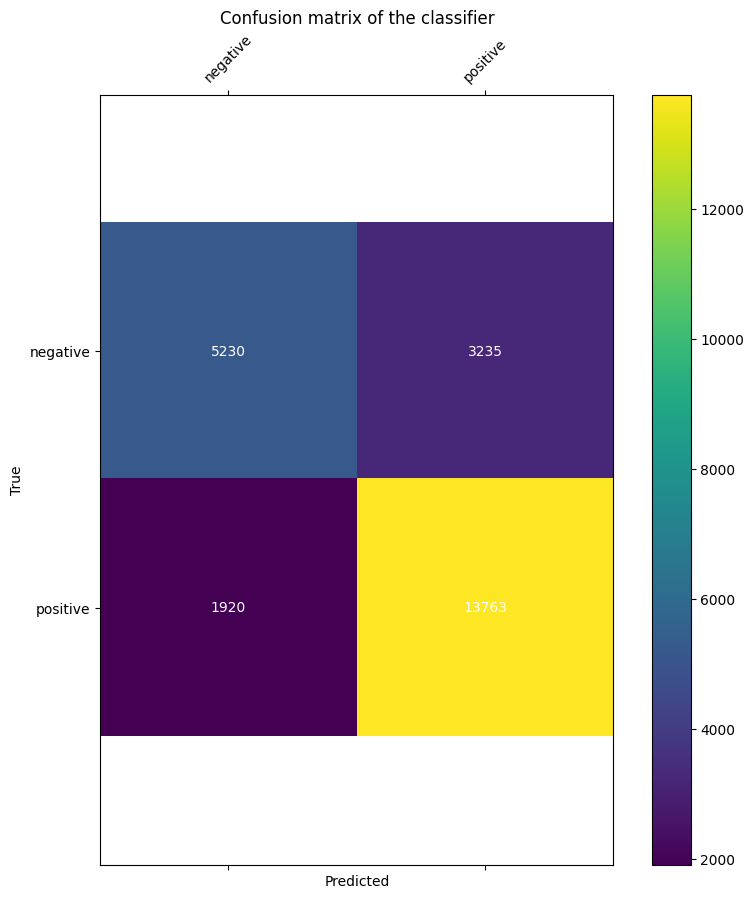

In [165]:
from sklearn import metrics
import matplotlib.pyplot as plt
# a function to make the confusion matrix readable and pretty
def confusion_matrix_heatmap(y_test, preds, labels):
    """Function to plot a confusion matrix"""
    # pass labels to the confusion matrix function to ensure right order
    # cm = metrics.confusion_matrix(y_test, preds, labels)
    cm = metrics.confusion_matrix(y_test, preds, labels=labels)
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the classifier')
    fig.colorbar(cax)
    ax.set_xticks(np.arange(len(labels)))
    ax.set_yticks(np.arange(len(labels)))
    ax.set_xticklabels( labels, rotation=45)
    ax.set_yticklabels( labels)

    for i in range(len(cm)):
        for j in range(len(cm)):
            text = ax.text(j, i, cm[i, j],
                           ha="center", va="center", color="w")
    false_positives = []
    false_negatives = []

    for i, (true_label, pred_label) in enumerate(zip(test2, predicted)):
        if true_label == 'FAKE' and pred_label != 'FAKE':
            false_negatives.append(i)
        elif true_label != 'FAKE' and pred_label == 'FAKE':
            false_positives.append(i)
   

                        

    plt.xlabel('Predicted')
    plt.ylabel('True')
    
    # fix for mpl bug that cuts off top/bottom of seaborn viz:
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show() # ta-da!
    plt.show()

# Data splitting into flods for cross validation
folds=len(train_data)//10
train1,train2=zip(*train_data[:folds])
test1,test2=zip(*train_data[folds:])

predicted=predict_labels(test1,train_classifier(list(zip(train1,train2))))#train classifier and predicted labels
confusion_matrix_heatmap(test2, predicted, labels=list(set(test2)))#cm

Optimising pre-processing and feature extraction

**Note:** it is advisable to implement question 5 in a separate notebook where you further develop the pre-processing and feature extraction functions you implemented above.

In [166]:
# Finally, check the accuracy of your classifier by training on all the traning data
# and testing on the test set
# Will only work once all functions are complete
functions_complete = True  # set to True once you're happy with your methods for cross val
if functions_complete:
    print(test_data[0])   # have a look at the first test data instance
    classifier = train_classifier(train_data)  # train the classifier
    test_true = [t[1] for t in test_data]   # get the ground-truth labels from the data
    test_pred = predict_labels([x[0] for x in test_data], classifier)  # classify the test data to get predicted labels
    final_scores = precision_recall_fscore_support(test_true, test_pred, average='weighted') # evaluate
    print("Done training!")
    print("Precision: %f\nRecall: %f\nF Score:%f" % final_scores[:3])

({'tomorrow': 1, 'we': 2, "'": 2, 'll': 2, 'release': 1, 'our': 2, '58th': 1, 'episode': 1, 'of': 1, '#hsonair': 1, 'profiling': 1, 'very': 1, 'own': 1, '@alissadossantos': 1, '!': 2, 'talk': 1, 'about': 1, 'storytelling': 1, 'and': 1, 'beyonce': 1}, 'positive')
Training Classifier...


c:\Users\nikhi\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


Done training!
Precision: 0.852690
Recall: 0.853906
F Score:0.853058
